# Analysis

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
import sys 

sys.path.append(os.path.join(os.getcwd(), '..'))
from facemap_tools.process_tools import create_procs
from facemap_tools.plotting import plot_area
import facemap

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Looking into pupil area plotted 

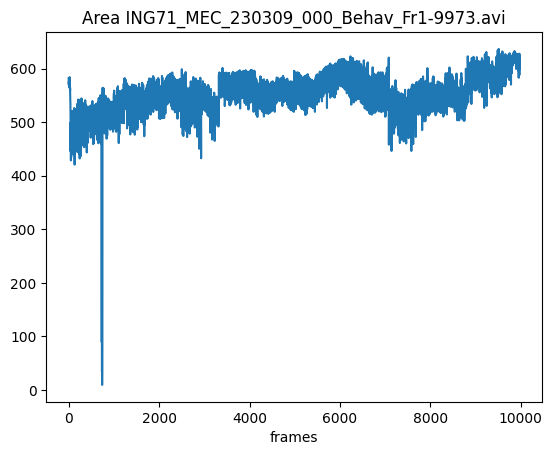

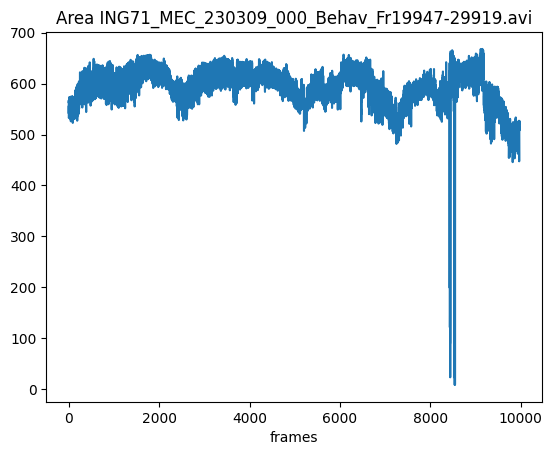

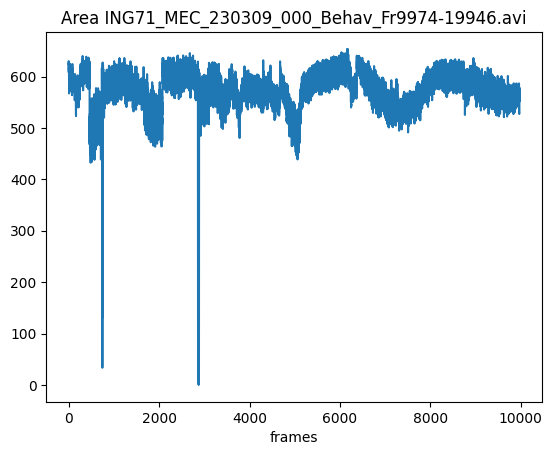

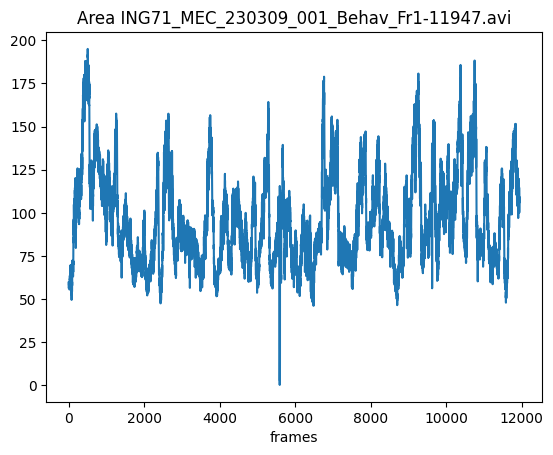

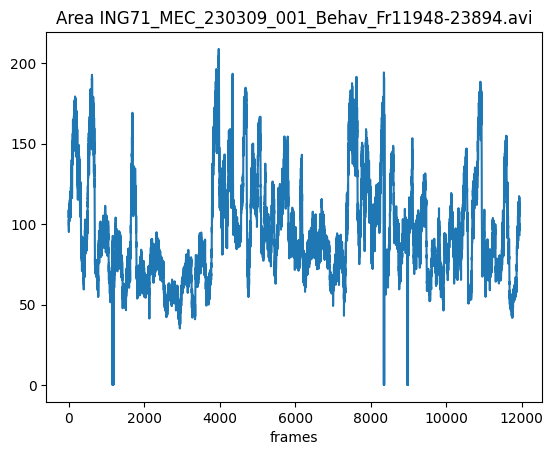

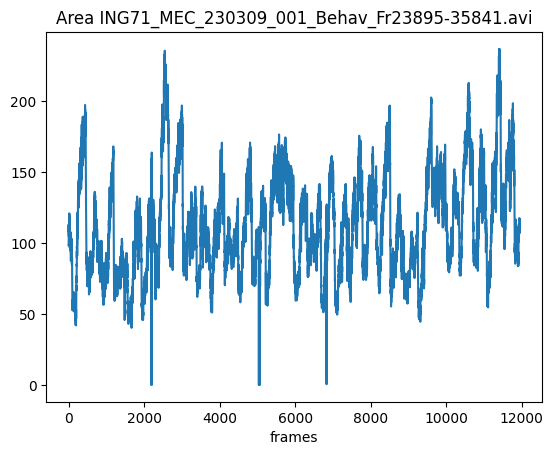

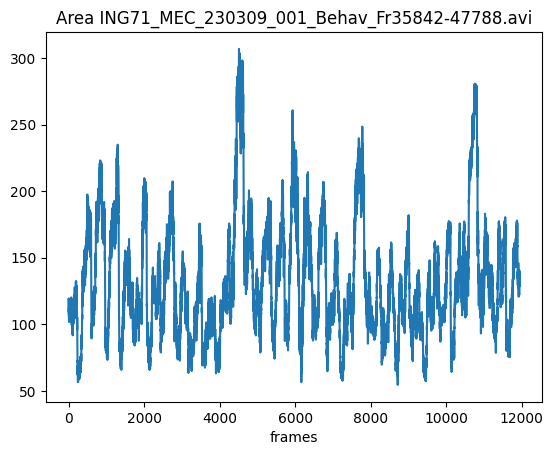

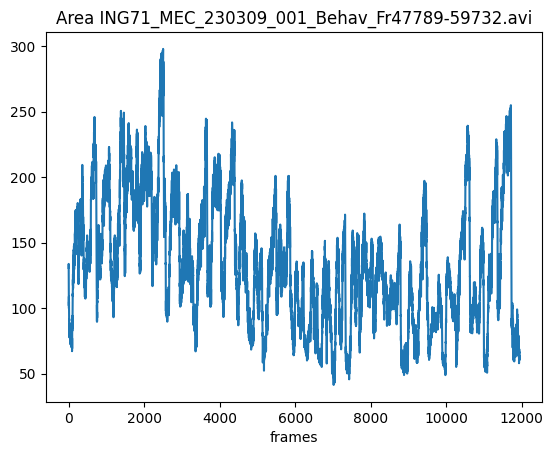

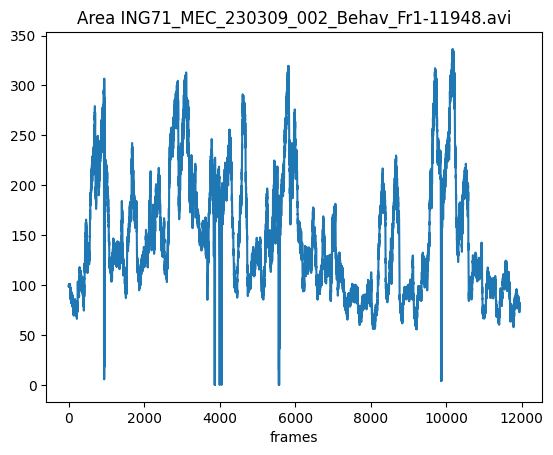

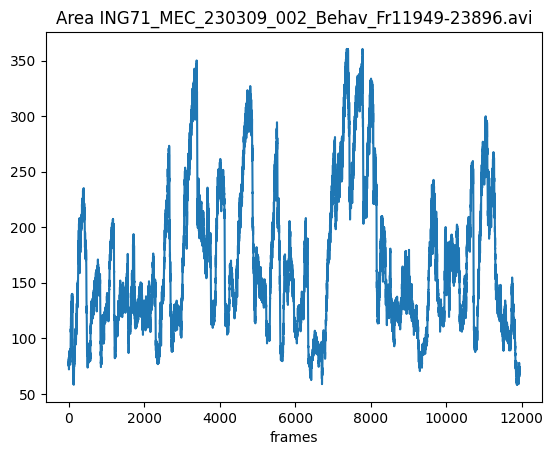

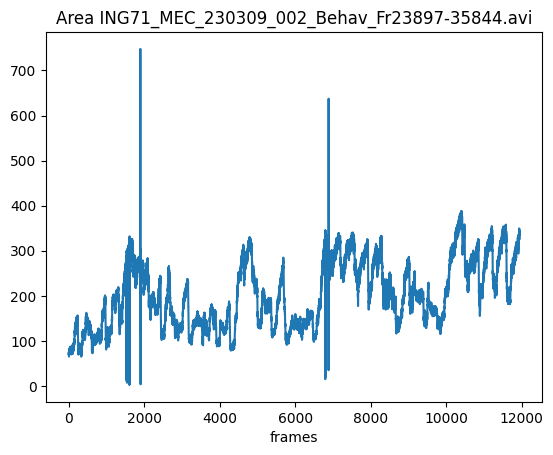

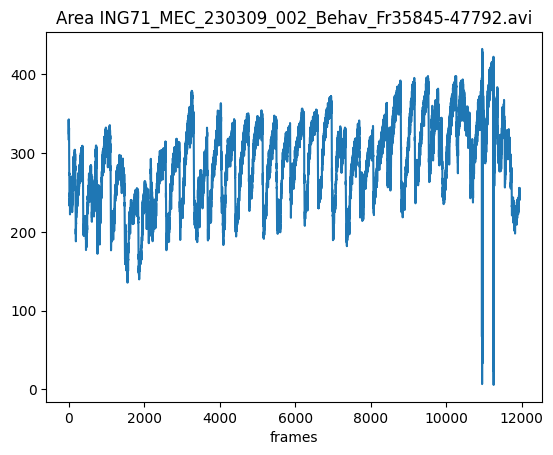

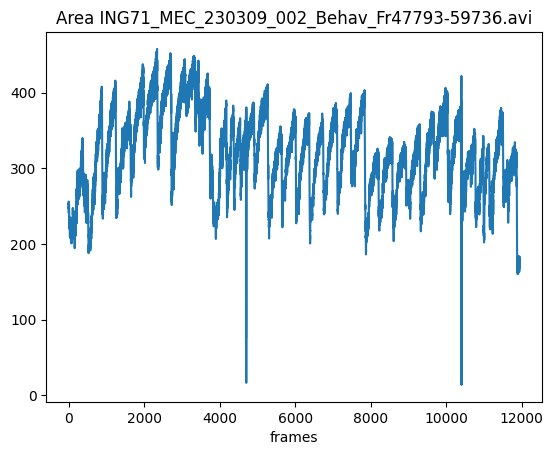

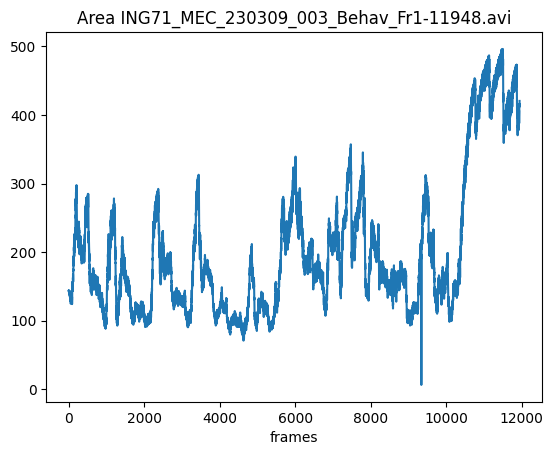

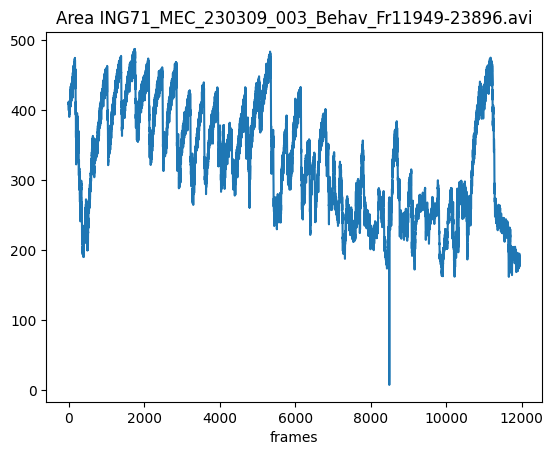

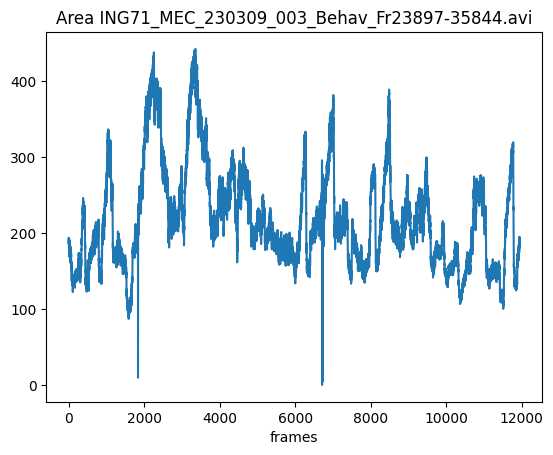

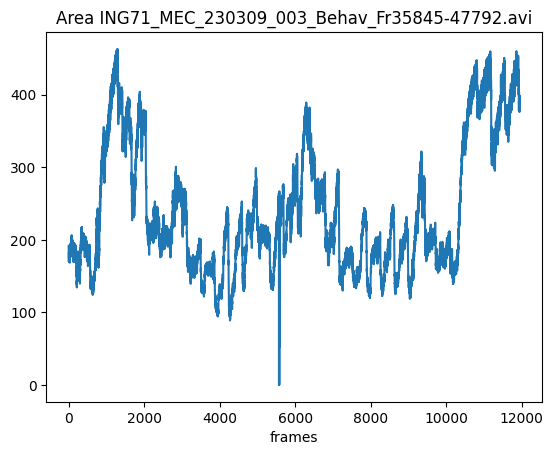

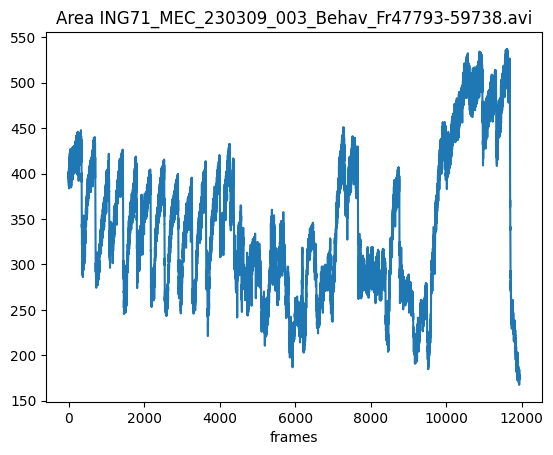

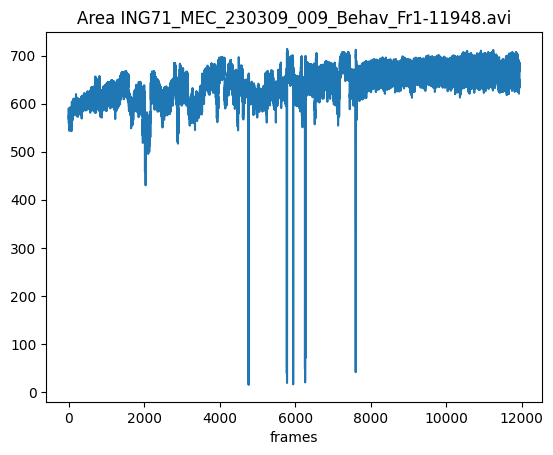

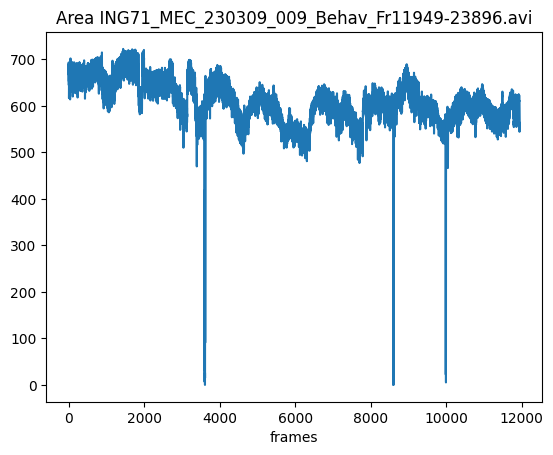

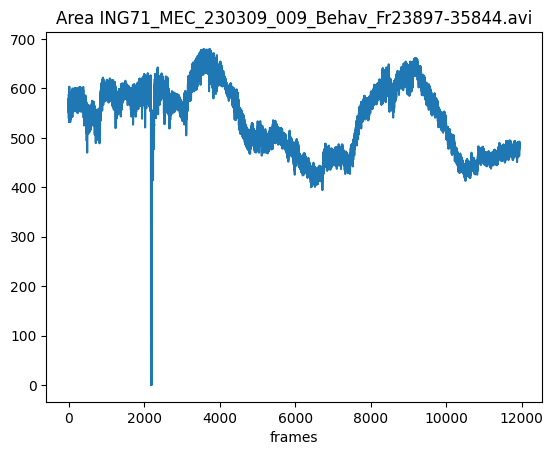

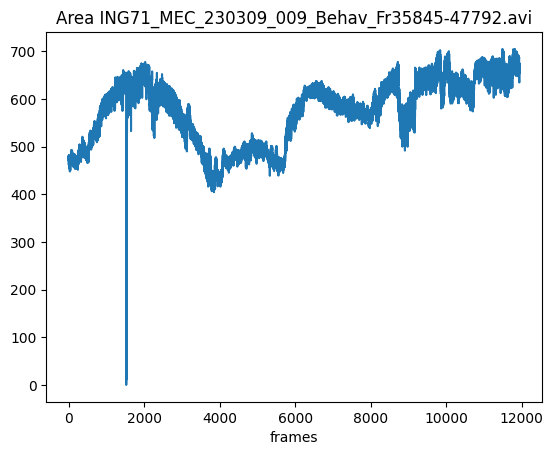

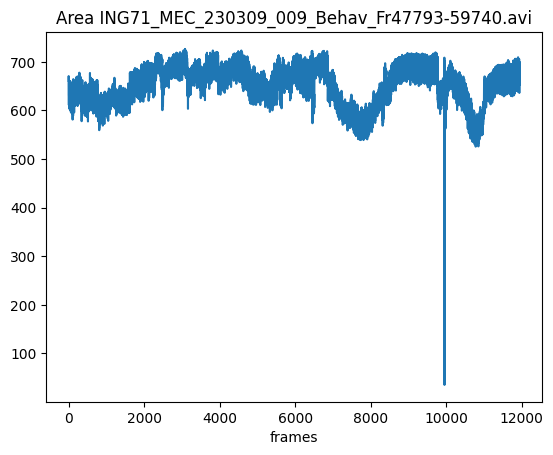

In [2]:
resultfolder = "/Volumes/T7/ING71_MEC_230309/AVI/resultsnpy"
procs = create_procs(resultfolder)
    

for filename in list(procs.keys()):
    proc = procs[filename]
    plot_area(proc)


In [3]:
print(proc.keys())
print(proc['pupil'][0].keys())
print(proc['pupil'][0]['area'])


dict_keys(['filenames', 'save_path', 'Ly', 'Lx', 'sbin', 'fullSVD', 'save_mat', 'Lybin', 'Lxbin', 'sybin', 'sxbin', 'LYbin', 'LXbin', 'avgframe', 'avgmotion', 'avgframe_reshape', 'avgmotion_reshape', 'motion', 'motSv', 'movSv', 'motMask', 'movMask', 'motMask_reshape', 'movMask_reshape', 'motSVD', 'movSVD', 'pupil', 'running', 'blink', 'rois', 'sy', 'sx'])
dict_keys(['area', 'com', 'axdir', 'axlen', 'area_smooth', 'com_smooth'])
[660.36490119 670.82364843 643.32511071 ... 668.46155737 700.14271964
 689.28873523]


(500.0, 800.0)

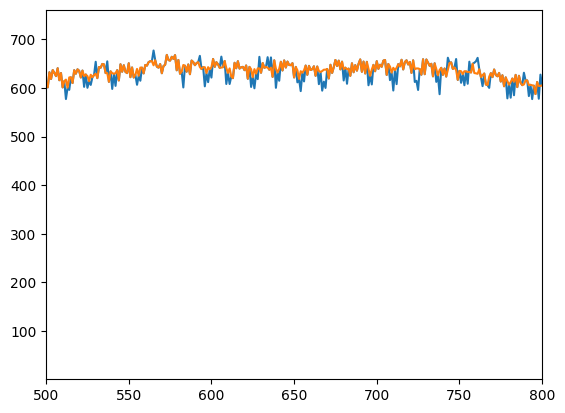

In [4]:
plt.plot(proc['pupil'][0]['area'])
plt.plot(proc['pupil'][0]['area_smooth'])
plt.xlim((500,800))
# plt.ylim((600,700))

In [5]:
print(procs.keys())

dict_keys(['ING71_MEC_230309_000_Behav_Fr1-9973_proc', 'ING71_MEC_230309_000_Behav_Fr19947-29919_proc', 'ING71_MEC_230309_000_Behav_Fr9974-19946_proc', 'ING71_MEC_230309_001_Behav_Fr1-11947_proc', 'ING71_MEC_230309_001_Behav_Fr11948-23894_proc', 'ING71_MEC_230309_001_Behav_Fr23895-35841_proc', 'ING71_MEC_230309_001_Behav_Fr35842-47788_proc', 'ING71_MEC_230309_001_Behav_Fr47789-59732_proc', 'ING71_MEC_230309_002_Behav_Fr1-11948_proc', 'ING71_MEC_230309_002_Behav_Fr11949-23896_proc', 'ING71_MEC_230309_002_Behav_Fr23897-35844_proc', 'ING71_MEC_230309_002_Behav_Fr35845-47792_proc', 'ING71_MEC_230309_002_Behav_Fr47793-59736_proc', 'ING71_MEC_230309_003_Behav_Fr1-11948_proc', 'ING71_MEC_230309_003_Behav_Fr11949-23896_proc', 'ING71_MEC_230309_003_Behav_Fr23897-35844_proc', 'ING71_MEC_230309_003_Behav_Fr35845-47792_proc', 'ING71_MEC_230309_003_Behav_Fr47793-59738_proc', 'ING71_MEC_230309_009_Behav_Fr1-11948_proc', 'ING71_MEC_230309_009_Behav_Fr11949-23896_proc', 'ING71_MEC_230309_009_Behav_Fr2

(100.0, 125.0)

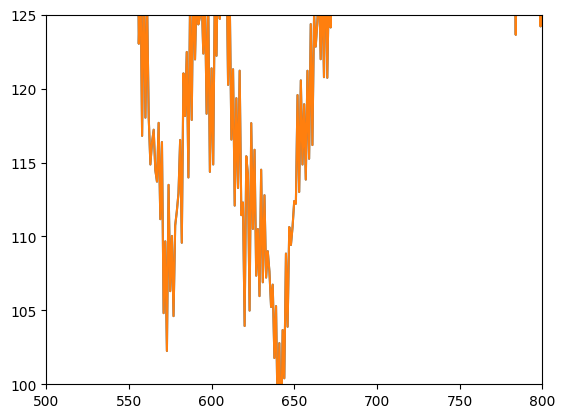

In [6]:
plt.plot(procs['ING71_MEC_230309_001_Behav_Fr1-11947_proc']['pupil'][0]['area'])
plt.plot(procs['ING71_MEC_230309_001_Behav_Fr1-11947_proc']['pupil'][0]['area_smooth'])
plt.xlim((500,800))
plt.ylim((100,125))

### Downsampling 

In [12]:
import scipy as sp

In [7]:
#Behavioral data

def get_experiment_n_day_k(n, k):
    #n is a string ex: '04', '10'
    #k is on the form yymmdd
    base = "/Volumes/T7/ING71_MEC_" + str(k)
    base = os.path.join(base, 'AVI')
    base = os.path.join(base, 'resultsnpy')

    behavior_base = "/Volumes/T7/mec-lec-por-data"
    files = os.listdir(base)

    experiment_base = 'ING71_MEC_' + str(k) + '_0' + n

    exp_filenames = [file for file in files if file[:20] == experiment_base]

    complete_proc = []
    for file in exp_filenames:
        proc = np.load(os.path.join(base, file), allow_pickle=True).item()
        complete_proc.extend(proc['pupil'][0]['area'])

    negative = np.load(os.path.join(behavior_base, experiment_base + '_negative.npy'), allow_pickle=True)
    positive = np.load(os.path.join(behavior_base, experiment_base + '_positive.npy'), allow_pickle=True)
    reward = np.load(os.path.join(behavior_base, experiment_base + '_reward.npy'), allow_pickle=True)
    aversive = np.load(os.path.join(behavior_base, experiment_base + '_aversive.npy'), allow_pickle=True)
    
    return complete_proc, negative, positive, reward, aversive

In [10]:
c_proc, negative ,positive, reward, aversive = get_experiment_n_day_k('03', 230309)

In [14]:
n_points = len(positive)
down_s_proc = sp.signal.resample(c_proc, n_points)

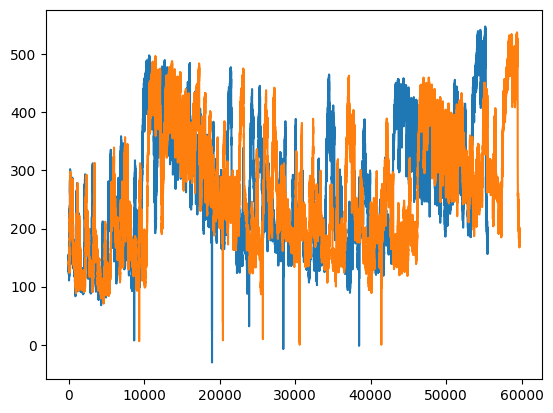

In [16]:
plt.plot(down_s_proc)
plt.plot(c_proc)

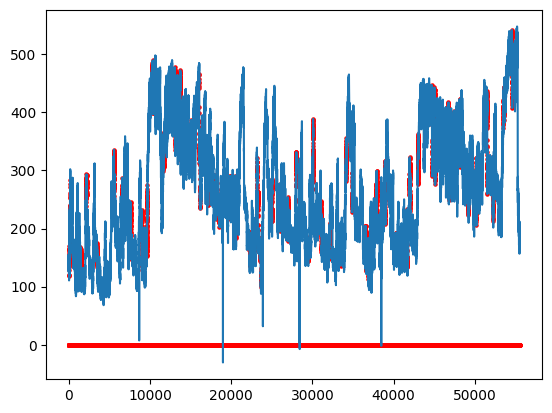

In [28]:
#Plot with downsampeled 
plt.plot(down_s_proc)
plt.scatter(np.arange(len(positive)), positive*down_s_proc, 5, color='r')
# plt.xlim(0,100)

In [ ]:
#Downsampling with decimate